# Day 12, Image classification

## So today I'll be bulding another image classifier with CNN and keras to classify cats vs dogs. I'll try to play with the data and see how the model performs.

### As usual, importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

### download the dataset

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  39.6M      0  0:00:19  0:00:19 --:--:-- 41.7M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

'MSR-LA - 3467.docx'   __notebook_source__.ipynb    'readme[1].txt'
 PetImages	       kagglecatsanddogs_3367a.zip


In [4]:
!ls PetImages

Cat  Dog


### some images are corrupted so we'll filter these out

In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


### so we had 1590 images that their extension was not in a proper format

### Creating the dataset, train, validation

In [6]:
image_size = (180, 180)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


### let's plot some images

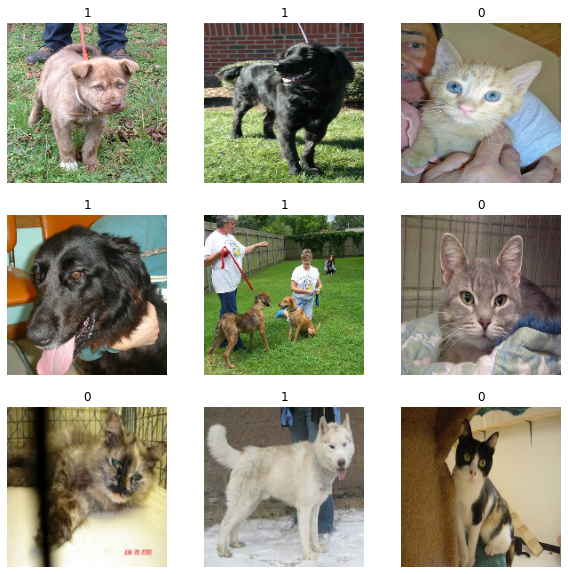

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### class 0 : cat, class 1 : dog

### Perform data augmentation to create more training samples.

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

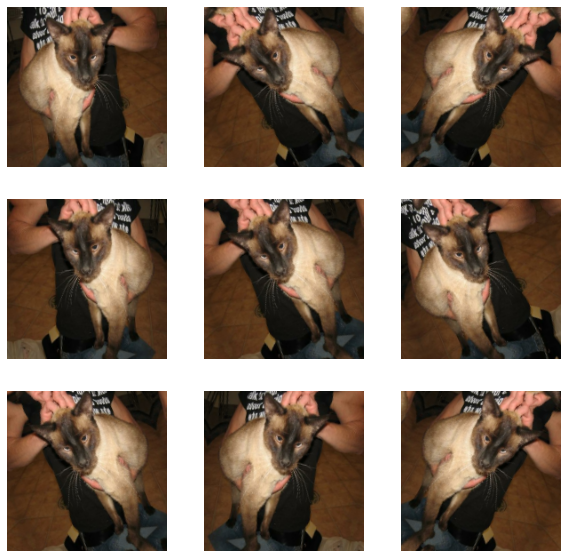

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### As usual, we'll normalize the data to become of type float and pixel values range from 0 to 1 insted 0 to 255 for faster training

In [10]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## building and training the model

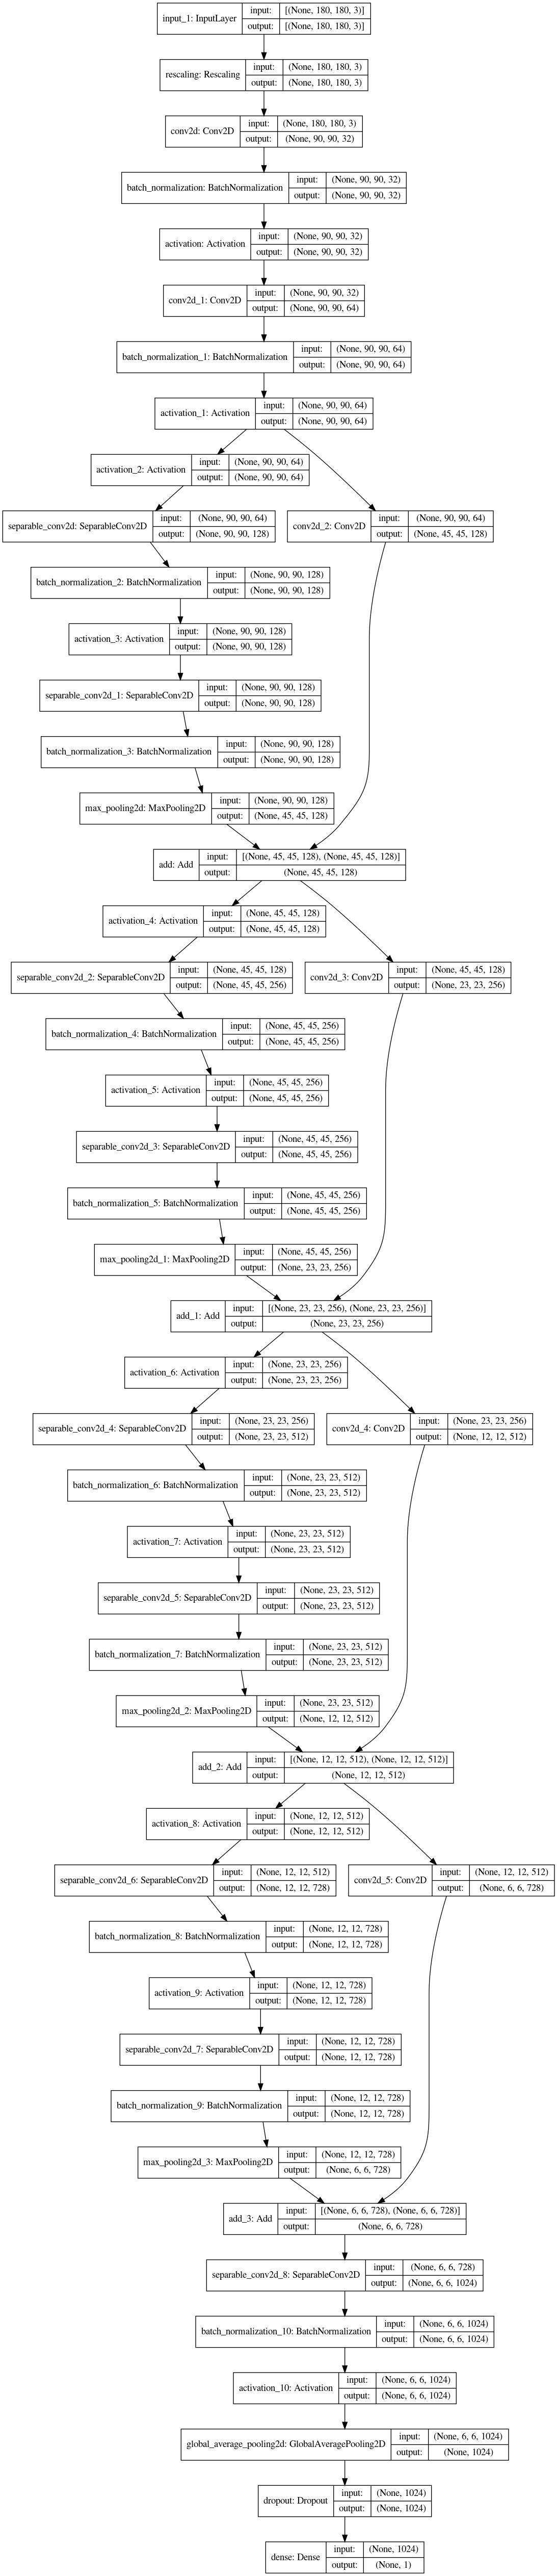

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = (inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 50

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=epochs,validation_data=val_ds,batch_size=64)

Epoch 1/50
293/293 [==============================] - 118s 376ms/step - loss: 0.6500 - accuracy: 0.6436 - val_loss: 0.9111 - val_accuracy: 0.4957
Epoch 2/50
293/293 [==============================] - 110s 372ms/step - loss: 0.3970 - accuracy: 0.8218 - val_loss: 0.5127 - val_accuracy: 0.7313
Epoch 3/50
293/293 [==============================] - 110s 372ms/step - loss: 0.2714 - accuracy: 0.8876 - val_loss: 0.2607 - val_accuracy: 0.8968
Epoch 4/50
293/293 [==============================] - 109s 371ms/step - loss: 0.1928 - accuracy: 0.9247 - val_loss: 0.2744 - val_accuracy: 0.9047
Epoch 5/50
293/293 [==============================] - 110s 373ms/step - loss: 0.1549 - accuracy: 0.9367 - val_loss: 0.2391 - val_accuracy: 0.9101
Epoch 6/50
293/293 [==============================] - 109s 371ms/step - loss: 0.1106 - accuracy: 0.9562 - val_loss: 0.2854 - val_accuracy: 0.9065
Epoch 7/50
293/293 [==============================] - 109s 371ms/step - loss: 0.0853 - accuracy: 0.9679 - val_loss: 0.3331 -

## The training proccess took about 45 minutes so I couldn't perform augmentation as a layer in the CNN it'd take forever.